In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input/fooddataset'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import sys
import shutil
from PIL import Image
from lxml import etree as ET
from tqdm import tqdm
from copy import deepcopy
import tensorflow as tf
import numpy as np
import cv2
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imgaug import augmenters as iaa

Populating the interactive namespace from numpy and matplotlib


In [3]:
print(os.getcwd())

/content


In [4]:
# print(os.listdir('/kaggle/input/')) 
print(tf.__version__)

2.2.0


In [5]:
# import keras
# from keras import layers
# from keras.layers import Input, Dense, Reshape, Lambda, Dropout, LeakyReLU, Activation, Flatten
# from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
# from keras.models import Model
# from keras.preprocessing import image
# import keras.backend as K
# # from keras.utils import layer_utils
# from keras.utils import Sequence
# # from keras.utils.data_utils import get_file
# from keras.applications.imagenet_utils import decode_predictions
# from keras.applications.imagenet_utils import preprocess_input
# # from tensorflow.keras_applications.imagenet_utils import _obtain_input_shape
# # from keras.engine.topology import get_source_inputs
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import InputLayer, Dense, Reshape, Lambda, Dropout, LeakyReLU, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
# from keras.utils import layer_utils
from tensorflow.keras.utils import Sequence
# from keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
# from tensorflow.keras_applications.imagenet_utils import _obtain_input_shape
# from keras.engine.topology import get_source_inputs
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [6]:
print(keras.__version__)

2.3.0-tf


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
Sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(Sess)

Num GPUs Available:  0
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



# Parameters

In [8]:
BASE_PATH = '/content/drive/My Drive/food-detection/' #'/kaggle/input/' 
LABELS = ['rice', 'roti', 'dal', 'sabzi']
 
IMAGE_H = 224
IMAGE_W = 224 # must equal to GRID_H * 32  416, 416
GRID_H, GRID_W = 7, 7        # 13, 13
N_BOX = 5
CLASS = len(LABELS)
CLASS_WEIGHTS = np.ones(4, dtype='float32')
OBJ_THRESHOLD = 0.3
NMS_THRESHOLD = 0.3
 
NO_OBJECT_SCALE = 1.0
OBJECT_SCALE = 5.0
COORD_SCALE = 1.0
CLASS_SCALE = 1.0
 
BATCH_SIZE = 64
WARM_UP_BATCHES = 0
TRUE_BOX_BUFFER = 50
LAMBDA_NO_OBJECT = 1.0
LAMBDA_OBJECT    = 5.0
LAMBDA_COORD     = 1.0
LAMBDA_CLASS     = 1.0

In [11]:
ANCHORS = []
with open( BASE_PATH + 'Dataset/generated_anchors_mobilenet/anchors_5.txt', 'r') as anchor_file:
    for i, line in enumerate(anchor_file):
        line = line.rstrip('\n')
        ANCHORS.append(list(map(float, line.split(', '))))
ANCHORS = list(list(np.array(ANCHORS).reshape(1, -1))[0])
print(ANCHORS)

[1.87, 1.85, 2.49, 3.02, 4.33, 2.47, 4.42, 4.48, 6.16, 5.72]


In [12]:
generator_config = {
    'IMAGE_H': IMAGE_H,
    'IMAGE_W': IMAGE_W,
    'GRID_H': GRID_H,
    'GRID_W': GRID_W,
    'BOX': N_BOX,
    'LABELS': LABELS,
    'CLASS': len(LABELS),
    'ANCHORS': ANCHORS,
    'BATCH_SIZE': BATCH_SIZE,
    'TRUE_BOX_BUFFER': TRUE_BOX_BUFFER,
}

# Input Layers

# Utils Functions

In [13]:
# Normalizing the image
def normalize(image):
    return image / 255.

In [14]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
# def space_to_depth_x2(x):
#     return tf.nn.space_to_depth(x, block_size=2)

In [15]:
def get_model():
    """ Build MobileNetV2 model """
    print('=> Building MobileNetV2 model...')
    input_image = tf.keras.Input(shape=(IMAGE_H, IMAGE_W, 3), name="input_image")
    true_boxes= tf.keras.Input(shape=(1, 1, 1, TRUE_BOX_BUFFER, 4), name="input_hack")
    mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet",include_top=False,
                                       input_shape=(224,224,3))
    for i, layer in enumerate(mobilenet.layers):
        layer.trainable=False
    #   print(i, layer.name)
    x = mobilenet(input_image)
    x = Conv2D(N_BOX * (4 + 1 + CLASS), (1, 1), strides=(1, 1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W, N_BOX, 4 + 1 + CLASS))(x)

    # small hack to allow true_boxes to be registered when Keras build the model
    # for more information: https://github.com/fchollet/keras/issues/2790
    output = Lambda(lambda args: args[0])([output, true_boxes])

    model = Model([input_image, true_boxes], output)
    print("=> Model Summary")
    print(model.summary())
    return (model, true_boxes)
'''
def get_model():
    input_image = Input(shape=(IMAGE_H, IMAGE_W, 3), name="input_image")
    true_boxes= Input(shape=(1, 1, 1, TRUE_BOX_BUFFER, 4), name="input_hack")
    # Layer 1
    x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
    x = BatchNormalization(name='norm_1')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 2
    x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
    x = BatchNormalization(name='norm_2')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 3
    x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
    x = BatchNormalization(name='norm_3')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 4
    x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
    x = BatchNormalization(name='norm_4')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 5
    x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
    x = BatchNormalization(name='norm_5')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 6
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
    x = BatchNormalization(name='norm_6')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 7
    x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
    x = BatchNormalization(name='norm_7')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 8
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
    x = BatchNormalization(name='norm_8')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 9
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
    x = BatchNormalization(name='norm_9')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 10
    x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
    x = BatchNormalization(name='norm_10')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 11
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
    x = BatchNormalization(name='norm_11')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 12
    x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
    x = BatchNormalization(name='norm_12')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 13
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
    x = BatchNormalization(name='norm_13')(x)
    x = LeakyReLU(alpha=0.1)(x)

    skip_connection = x

    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 14
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
    x = BatchNormalization(name='norm_14')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 15
    x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
    x = BatchNormalization(name='norm_15')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 16
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
    x = BatchNormalization(name='norm_16')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 17
    x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
    x = BatchNormalization(name='norm_17')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 18
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
    x = BatchNormalization(name='norm_18')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 19
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
    x = BatchNormalization(name='norm_19')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 20
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
    x = BatchNormalization(name='norm_20')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 21
    skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
    skip_connection = BatchNormalization(name='norm_21')(skip_connection)
    skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
    skip_connection = Lambda(space_to_depth_x2)(skip_connection)
    
#     print(type(skip_connection))
#     print(type(x))
    # x = layers.Concatenate()([skip_connection, x])
    x = tf.layers.layers.Concatenate()([skip_connection, x])

    # Layer 22
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
    x = BatchNormalization(name='norm_22')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 23
    x = Conv2D(N_BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W, N_BOX, 4 + 1 + CLASS))(x)

    # small hack to allow true_boxes to be registered when Keras build the model 
    # for more information: https://github.com/fchollet/keras/issues/2790
    output = Lambda(lambda args: args[0])([output, true_boxes])

    model = Model([input_image, true_boxes], output)
    print("=> Model Summary")
    print(model.summary())
    return model, true_boxes
'''


'\ndef get_model():\n    input_image = Input(shape=(IMAGE_H, IMAGE_W, 3), name="input_image")\n    true_boxes= Input(shape=(1, 1, 1, TRUE_BOX_BUFFER, 4), name="input_hack")\n    # Layer 1\n    x = Conv2D(32, (3,3), strides=(1,1), padding=\'same\', name=\'conv_1\', use_bias=False)(input_image)\n    x = BatchNormalization(name=\'norm_1\')(x)\n    x = LeakyReLU(alpha=0.1)(x)\n    x = MaxPooling2D(pool_size=(2, 2))(x)\n\n    # Layer 2\n    x = Conv2D(64, (3,3), strides=(1,1), padding=\'same\', name=\'conv_2\', use_bias=False)(x)\n    x = BatchNormalization(name=\'norm_2\')(x)\n    x = LeakyReLU(alpha=0.1)(x)\n    x = MaxPooling2D(pool_size=(2, 2))(x)\n\n    # Layer 3\n    x = Conv2D(128, (3,3), strides=(1,1), padding=\'same\', name=\'conv_3\', use_bias=False)(x)\n    x = BatchNormalization(name=\'norm_3\')(x)\n    x = LeakyReLU(alpha=0.1)(x)\n\n    # Layer 4\n    x = Conv2D(64, (1,1), strides=(1,1), padding=\'same\', name=\'conv_4\', use_bias=False)(x)\n    x = BatchNormalization(name=\'no

In [16]:
@tf.function
def custom_loss(data, y_pred):
    
    y_true = data[...,0:9]
    y_true_box = data[:,0:1,0:1,:,9:13]
    # print(tf.shape(y_true))
    # print(tf.shape(y_true_box))
    # print(tf.shape(y_pred))
    
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.compat.v1.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, N_BOX, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,N_BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    
    tx = y_true_box[..., 0:2]
    tw = y_true_box[..., 2:4]
    true_xy = tf.expand_dims(tx,3)
    true_wh = tf.expand_dims(tw,3)
    # print(tx[7][7][0], tw[7][7][0])
    # true_xy = tf.expand_dims(true_box_xy, 4)
    # true_wh = tf.expand_dims(true_box_wh, 4)
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + (tf.compat.v1.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE)
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.compat.v1.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.compat.v1.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,N_BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.compat.v1.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.compat.v1.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.compat.v1.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = tf.math.add(tf.math.add(loss_xy, loss_wh), tf.math.add(loss_conf, loss_class))
    
#     nb_true_box = tf.reduce_sum(y_true[..., 4])
#     nb_pred_box = tf.reduce_sum(tf.compat.v1.to_float(true_box_conf > 0.5) * tf.compat.v1.to_float(pred_box_conf > 0.3))

    """
    Debugging code
       
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.compat.v1.assign_add(total_recall, current_recall) 

    loss = tf.compat.v1.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.compat.v1.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.compat.v1.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.compat.v1.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.compat.v1.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.compat.v1.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.compat.v1.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.compat.v1.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    """
    return loss

In [ ]:
# help(custom_loss)

In [17]:
tf.config.experimental_run_functions_eagerly(True)
# tf.config.run_functions_eagerly(True)

In [18]:
def train(model, true_boxes, one_fold, model_save_name):
    layer = model.layers[-4]
    weights = layer.get_weights()

    new_kernel = np.random.normal(size=weights[0].shape) / (GRID_H * GRID_W)
    new_bias = np.random.normal(size=weights[1].shape) / (GRID_H * GRID_W)

    layer.set_weights([new_kernel, new_bias])

    early_stop = EarlyStopping(monitor='val_loss',
                               min_delta=0.001,
                               patience=3,
                               mode='min',
                               verbose=1)

    checkpoint = ModelCheckpoint(os.path.join(BASE_PATH,'all_imgs_mobile_net_loss.h5'),
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min')
                                 #save_freq='epoch')

    train_batch, valid_batch = one_fold

    '''
    if not os.path.exists(os.path.join(BASE_PATH,'tl_tf_logs')):
        os.mkdir(os.path.join(BASE_PATH,'tl_tf_logs'))
        
    tb_counter = len([log for log in os.listdir(os.path.join(BASE_PATH,'tl_tf_logs')) if 'food' in log]) + 1
    tensorboard = TensorBoard(log_dir=os.path.join(BASE_PATH, 'mess') + '/all_imgs_mobile_net' + '_' + str(tb_counter),
                              histogram_freq=0,
                              write_graph=True,
                              write_images=False)
    '''
    optimizer = Adam(
        lr= 1e-4,
        beta_1= 0.9,
        beta_2= 0.999,
        epsilon= 1e-08,
        decay= 0.0
    )
    # Compile model with custom loss function
    model.compile(loss=custom_loss, optimizer=optimizer, metrics=['accuracy'])
    print("Model compiled successfully!")
    # Start training
    model.fit(
        train_batch,
        steps_per_epoch=len(train_batch),
        epochs=20,
        verbose=1,
        validation_data=valid_batch,
        validation_steps=len(valid_batch),
        callbacks=[early_stop, checkpoint],
#         callbacks=[early_stop, checkpoint], tensorboard],
        max_queue_size=3 
    )
    print("Model trained successfully!")
    # Write the model on file
    # model.save(os.path.join(BASE_PATH, "food_trained_model_full.h5"))
    model.save(os.path.join(BASE_PATH, model_save_name))
    print("Model saved!!")
    return model
    

In [19]:
def parse_annotation(ann_dir, img_dir, labels=[]):
    all_imgs = []
    seen_labels = {}

    for ann in tqdm(sorted(os.listdir(ann_dir))):
        img = {'object': []}

        if ann == '.DS_Store':
          continue
        tree = ET.parse(ann_dir + ann)

        for elem in tree.iter():
            if 'filename' in elem.tag:
                img['filename'] = os.path.join(img_dir, elem.text)
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}

                for attr in list(elem):
                    if 'name' in attr.tag:
                        obj['name'] = attr.text

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']] = 1

                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]

                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]

    return all_imgs, seen_labels

In [20]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, c=None, classes=None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax

        self.c = c
        self.classes = classes

        self.label = -1
        self.score = -1

    def __str__(self):
        return "xmin: {}, ymin: {}, xmax: {}, ymax: {}, class: {}".format(self.xmin, self.ymin, self.xmax, self.ymax, self.label)

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score

    def get_conf(self):

        return self.c

In [21]:
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])

    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax - box1.xmin, box1.ymax - box1.ymin
    w2, h2 = box2.xmax - box2.xmin, box2.ymax - box2.ymin

    union = w1 * h1 + w2 * h2 - intersect

    return float(intersect) / union

In [22]:
def draw_boxes(image, boxes, labels):
    image_h, image_w, _ = image.shape

    for box in boxes:
        print(box)
        xmin = int(box['xmin'])
        ymin = int(box['ymin'])
        xmax = int(box['xmax'])
        ymax = int(box['ymax'])

        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 255), 1)
        cv2.putText(image,
                    box['name'],
                    # labels[box.get_label()] + ' ' + str(box.get_score()),
                    (xmin, ymin - 13),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1e-2 * image_h,
                    (0, 255, 255), 1)

    return image


In [23]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2, x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2, x4) - x3

In [24]:
def decode_netout(netout, anchors, nb_class, obj_threshold=0.1, nms_threshold=0.3):
    grid_h, grid_w, nb_box = netout.shape[:3]
    boxes = []

    # decode the output by the network
    netout[..., 4] = _sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_threshold

    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                # from 4th element onwards are confidence and class classes
                classes = netout[row, col, b, 5:]

                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout[row, col, b, :4]

                    x = (col + _sigmoid(x)) / grid_w  # center position, unit: image width
                    y = (row + _sigmoid(y)) / grid_h  # center position, unit: image height
                    w = anchors[2 * b + 0] * np.exp(w) / grid_w  # unit: image width
                    h = anchors[2 * b + 1] * np.exp(h) / grid_h  # unit: image height
                    confidence = netout[row, col, b, 4]

                    box = BoundBox(x - w / 2, y - h / 2, x + w / 2, y + h / 2, confidence, classes)

                    boxes.append(box)

    # suppress non-maximal boxes
    for c in range(nb_class):
        sorted_indices = list(reversed(np.argsort([box.classes[c] for box in boxes])))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0:
                continue
            else:
                for j in range(i + 1, len(sorted_indices)):
                    index_j = sorted_indices[j]

                    if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
                        boxes[index_j].classes[c] = 0

    # remove the boxes which are less likely than a obj_threshold
    boxes = [box for box in boxes if box.get_score() > obj_threshold]

    return boxes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [25]:
class BatchGenerator(Sequence):
    def __init__(self, images,
                 config,
                 shuffle=True,
                 jitter=True,
                 norm=None):
        self.generator = None
        self.n = 0
        
        self.images = images
        self.config = config

        self.shuffle = shuffle
        self.jitter = jitter
        self.norm = norm

        self.anchors = [BoundBox(0, 0, config['ANCHORS'][2 * i], config['ANCHORS'][2 * i + 1]) for i in
                        range(int(len(config['ANCHORS']) // 2))]
        self.max = self.__len__()

        ### augmentors by https://github.com/aleju/imgaug
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)
        # Define our sequence of augmentation steps that will be applied to every image
        # All augmenters with per_channel=0.5 will sample one value _per image_
        # in 50% of all cases. In all other cases they will sample new values
        # _per channel_.
        self.aug_pipe = iaa.Sequential(
            [
                # apply the following augmenters to most images
                # iaa.Fliplr(0.5), # horizontally flip 50% of all images
                # iaa.Flipud(0.2), # vertically flip 20% of all images
                # sometimes(iaa.Crop(percent=(0, 0.1))), # crop images by 0-10% of their height/width
                sometimes(iaa.Affine(
                    # scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                    # translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                    # rotate=(-5, 5), # rotate by -45 to +45 degrees
                    # shear=(-5, 5), # shear by -16 to +16 degrees
                    # order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                    # cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                    # mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                )),
                # execute 0 to 5 of the following (less important) augmenters per image
                # don't execute all of them, as that would often be way too strong
                iaa.SomeOf((0, 5),
                           [
                               # sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                               iaa.OneOf([
                                   iaa.GaussianBlur((0, 3.0)),  # blur images with a sigma between 0 and 3.0
                                   iaa.AverageBlur(k=(2, 7)),
                                   # blur image using local means with kernel sizes between 2 and 7
                                   iaa.MedianBlur(k=(3, 11)),
                                   # blur image using local medians with kernel sizes between 2 and 7
                               ]),
                               iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),  # sharpen images
                               # iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                               # search either for all edges or for directed edges
                               # sometimes(iaa.OneOf([
                               #    iaa.EdgeDetect(alpha=(0, 0.7)),
                               #    iaa.DirectedEdgeDetect(alpha=(0, 0.7), direction=(0.0, 1.0)),
                               # ])),
                               iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5),
                               # add gaussian noise to images
                               iaa.OneOf([
                                   iaa.Dropout((0.01, 0.1), per_channel=0.5),  # randomly remove up to 10% of the pixels
                                   # iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                               ]),
                               # iaa.Invert(0.05, per_channel=True), # invert color channels
                               iaa.Add((-10, 10), per_channel=0.5),
                               # change brightness of images (by -10 to 10 of original value)
                               iaa.Multiply((0.5, 1.5), per_channel=0.5),
                               # change brightness of images (50-150% of original value)
                               iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),  # improve or worsen the contrast
                               # iaa.Grayscale(alpha=(0.0, 1.0)),
                               # sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                               # sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))) # sometimes move parts of the image around
                           ],
                           random_order=True
                           )
            ],
            random_order=True
        )

        if shuffle:
            np.random.shuffle(self.images)

    def __len__(self):
        return int(np.ceil(float(len(self.images)) / self.config['BATCH_SIZE']))

    def __next__(self):
        if self.n >= self.max:
           self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1
        return result
    def num_classes(self):
        return len(self.config['LABELS'])

    def size(self):
        return len(self.images)

    def load_annotation(self, i):
        annots = []

        for obj in self.images[i]['object']:
            print(obj['name'])
            # if obj['name'][-1] == ' ':
            #     obj['name'] = obj['name'][:-1]
            # if obj['name'] == 'fermented soybeans':
            #     obj['name'] = 'natto'
            # if obj['name'] == 'beef steak':
            #     obj['name'] = 'steak'
            # if obj['name'] == 'rolled omelet':
            #     obj['name'] = 'omelet'
            annot = [obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax'], self.config['LABELS'].index(obj['name'])]
            annots += [annot]

        if len(annots) == 0:
            annots = [[]]

        return np.array(annots)

    def load_image(self, i):
        isExist = os.path.exists(self.images[i]['filename']) 
        print(isExist) 
        return cv2.imread(self.images[i]['filename'])

    def __getitem__(self, idx):
        l_bound = idx * self.config['BATCH_SIZE']
        r_bound = (idx + 1) * self.config['BATCH_SIZE']

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        instance_count = 0

        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))  # input images
        b_batch = np.zeros((r_bound - l_bound, 1, 1, 1, self.config['TRUE_BOX_BUFFER'],
                            4))  # list of self.config['TRUE_self.config['BOX']_BUFFER'] GT boxes
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'], self.config['GRID_W'], self.config['BOX'],
                            4 + 1 + len(self.config['LABELS'])+4))  # desired network output

        # y_batch_box = np.zeros((r_bound - l_bound, self.config['GRID_H'], self.config['GRID_W'], self.config['BOX'],
        #                     4 + 1 + len(self.config['LABELS']) + 4)
        for train_instance in self.images[l_bound:r_bound]:
            # augment input image and fix object's position and size
            img, all_objs = self.aug_image(train_instance, jitter=self.jitter)

            # construct output from object's x, y, w, h
            true_box_index = 0

            for obj in all_objs:
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x = .5 * (obj['xmin'] + obj['xmax'])
                    center_x = center_x / (float(self.config['IMAGE_W']) / self.config['GRID_W'])
                    center_y = .5 * (obj['ymin'] + obj['ymax'])
                    center_y = center_y / (float(self.config['IMAGE_H']) / self.config['GRID_H'])

                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        obj_indx = self.config['LABELS'].index(obj['name'])

                        center_w = (obj['xmax'] - obj['xmin']) / (
                                float(self.config['IMAGE_W']) / self.config['GRID_W'])  # unit: grid cell
                        center_h = (obj['ymax'] - obj['ymin']) / (
                                float(self.config['IMAGE_H']) / self.config['GRID_H'])  # unit: grid cell

                        box = [center_x, center_y, center_w, center_h]

                        # find the anchor that best predicts this box
                        best_anchor = -1
                        max_iou = -1

                        shifted_box = BoundBox(0,
                                               0,
                                               center_w,
                                               center_h)

                        for i in range(len(self.anchors)):
                            anchor = self.anchors[i]
                            iou = bbox_iou(shifted_box, anchor)

                            if max_iou < iou:
                                best_anchor = i
                                max_iou = iou

                        # assign ground truth x, y, w, h, confidence and class probs to y_batch
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4] = 1.
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5 + obj_indx] = 1
                        
                        y_batch[instance_count, 0, 0, true_box_index, 9:13] = box
                        

                        # assign the true box to b_batch
                        b_batch[instance_count, 0, 0, 0, true_box_index] = box
                        

                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']

            # assign input image to x_batch
            if self.norm is not None:
                x_batch[instance_count] = self.norm(img)
            else:
                # plot image and bounding boxes for sanity check
                for obj in all_objs:
                    if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin']:
                        cv2.rectangle(img[:, :, ::-1], (obj['xmin'], obj['ymin']), (obj['xmax'], obj['ymax']),
                                      (255, 0, 0), 3)
                        cv2.putText(img[:, :, ::-1], obj['name'],
                                    (obj['xmin'] + 2, obj['ymin'] + 12),
                                    0, 1.2e-3 * img.shape[0],
                                    (0, 255, 0), 2)

                x_batch[instance_count] = img

            # increase instance counter in current batch
            instance_count += 1

            # print(' new batch created', idx)

        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.images)

    def aug_image(self, train_instance, jitter):
        image_name = train_instance['filename']
        image = cv2.imread(image_name)

        if image is None:
            print('Cannot find ', image_name)

        h, w, c = image.shape
        all_objs = deepcopy(train_instance['object'])

        if jitter:
            ### scale the image
            scale = np.random.uniform() / 10. + 1.
            image = cv2.resize(image, (0, 0), fx=scale, fy=scale)

            ### translate the image
            max_offx = (scale - 1.) * w
            max_offy = (scale - 1.) * h
            offx = int(np.random.uniform() * max_offx)
            offy = int(np.random.uniform() * max_offy)

            image = image[offy: (offy + h), offx: (offx + w)]

            ### flip the image
            flip = np.random.binomial(1, .5)
            if flip > 0.5:
                image = cv2.flip(image, 1)

            image = self.aug_pipe.augment_image(image)

        # resize the image to standard size
        image = cv2.resize(image, (self.config['IMAGE_H'], self.config['IMAGE_W']))
        image = image[:, :, ::-1]

        # fix object's position and size
        for obj in all_objs:
            for attr in ['xmin', 'xmax']:
                if jitter:
                    obj[attr] = int(obj[attr] * scale - offx)

                # convert annotation from raw size to net input size
                obj[attr] = int(obj[attr] * float(self.config['IMAGE_W']) / w)
                obj[attr] = max(min(obj[attr], self.config['IMAGE_W']), 0)

            for attr in ['ymin', 'ymax']:
                if jitter:
                    obj[attr] = int(obj[attr] * scale - offy)

                # convert annotation from raw size to net input size
                obj[attr] = int(obj[attr] * float(self.config['IMAGE_H']) / h)
                obj[attr] = max(min(obj[attr], self.config['IMAGE_H']), 0)

            if jitter and flip > 0.5:
                xmin = obj['xmin']
                obj['xmin'] = self.config['IMAGE_W'] - obj['xmax']
                obj['xmax'] = self.config['IMAGE_W'] - xmin

        return image, all_objs

# Load Dataset

In [35]:
all_imgs = []
for i in range(0, len(LABELS)):
    image_path = os.path.join(BASE_PATH, "Dataset", str(i+1)) #'Dataset/' + str(i+1) + '/'
    annot_path = os.path.join(BASE_PATH, "Dataset", str(i+1), "annotations/") #'Dataset' + str(i+1) + '/' + '/annotations/'

    folder_imgs, seen_labels = parse_annotation(annot_path, image_path, labels=LABELS)
    all_imgs.extend(folder_imgs)

print(len(all_imgs))

100%|██████████| 693/693 [00:02<00:00, 339.49it/s]

2381


In [27]:
img_test = all_imgs[151]

In [28]:
img_test

{'filename': '/content/drive/My Drive/food-detection/Dataset/1/1224.jpg',
 'height': 224,
 'object': [{'name': 'rice', 'xmax': 56, 'xmin': 0, 'ymax': 64, 'ymin': 0}],
 'width': 224}

{'name': 'rice', 'xmin': 0, 'ymin': 0, 'xmax': 56, 'ymax': 64}


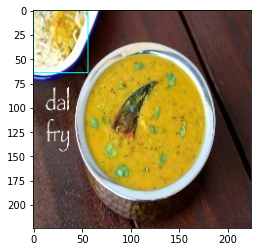

In [29]:
img = mpimg.imread(img_test['filename'])
box = img_test['object']
plt.imshow(draw_boxes(img, box, LABELS))

In [30]:
# # add extensions to image name
# for img in all_imgs:
#     img['filename'] = img['filename']

In [31]:
print('=> Generate BatchGenerator.')
batches = BatchGenerator(all_imgs, generator_config)

=> Generate BatchGenerator.


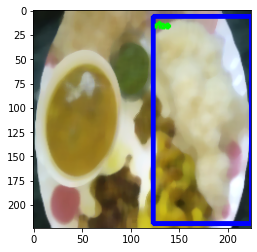

In [32]:
img = batches[0][0][0][5]
plt.imshow(img.astype('uint8'))

In [48]:
print(len(all_imgs))
# train_valid_split = int(0.9 * len(all_imgs))
print(train_valid_split)
# train_batch = BatchGenerator(all_imgs[:train_valid_split], generator_config, norm=normalize)
# valid_batch = BatchGenerator(all_imgs[train_valid_split:], generator_config, norm=normalize, jitter=False)

train_valid_split = len(all_imgs) // 5
print(train_valid_split)
kfolds = []
print(len(all_imgs[:train_valid_split]))
valid_batch = BatchGenerator(all_imgs[:train_valid_split], generator_config, norm=normalize, shuffle=False)
train_batch = BatchGenerator(all_imgs[train_valid_split:], generator_config, norm=normalize, shuffle=False)
print("\t", len(train_batch), len(valid_batch))
kfolds.append((train_batch, valid_batch))

valid_batch = BatchGenerator(all_imgs[train_valid_split: 2*train_valid_split], generator_config, norm=normalize, shuffle=False)
train_batch = BatchGenerator(all_imgs[:train_valid_split] + all_imgs[2*train_valid_split:], generator_config, norm=normalize, shuffle=False)
print("\t", len(train_batch), len(valid_batch))
kfolds.append((train_batch, valid_batch))

valid_batch = BatchGenerator(all_imgs[2*train_valid_split: 3*train_valid_split], generator_config, norm=normalize, shuffle=False)
train_batch = BatchGenerator(all_imgs[:2*train_valid_split:] + all_imgs[3*train_valid_split:], generator_config, norm=normalize, shuffle=False)
print("\t", len(train_batch), len(valid_batch))
kfolds.append((train_batch, valid_batch))

valid_batch = BatchGenerator(all_imgs[3*train_valid_split: 4*train_valid_split], generator_config, norm=normalize, shuffle=False)
train_batch = BatchGenerator(all_imgs[:3*train_valid_split:] + all_imgs[4*train_valid_split:], generator_config, norm=normalize, shuffle=False)
print("\t", len(train_batch), len(valid_batch))
kfolds.append((train_batch, valid_batch))

valid_batch = BatchGenerator(all_imgs[4*train_valid_split:], generator_config, norm=normalize, shuffle=False)
train_batch = BatchGenerator(all_imgs[:4*train_valid_split], generator_config, norm=normalize, shuffle=False)
print("\t", len(train_batch), len(valid_batch))
kfolds.append((train_batch, valid_batch))


print(len(train_batch))

print(len(valid_batch))

2381
476
476
476
	 30 8
	 30 8
	 30 8
	 30 8
	 30 8
30
8


In [44]:
for i in kfolds:
    print(len(i[0]), len(i[1]))

30 8
30 8
30 8
30 8
30 8


In [41]:
[X_batch,B_batch],Y_batch = train_batch.__getitem__(9)
print("x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = {}".format(X_batch.shape))
# print("y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = {}".format(Y_batch[1]))
print("y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = {}".format(Y_batch[0][0][0][0]))
print("b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = {}".format(B_batch[0][0][0][0][0]))

x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = (64, 224, 224, 3)
y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = [0.       0.       0.       0.       0.       0.       0.       0.
 0.       4.890625 1.359375 2.53125  2.71875 ]
b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = [4.890625 1.359375 2.53125  2.71875 ]


# Training

In [42]:
model, true_boxes = get_model()

=> Building MobileNetV2 model...
9412608/9406464 [==============================] - 0s 0us/step
=> Model Summary
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Model)    (None, 7, 7, 1280)   2257984     input_image[0][0]                
__________________________________________________________________________________________________
conv_23 (Conv2D)                (None, 7, 7, 45)     57645       mobilenetv2_1.00_224[1][0]       
__________________________________________________________________________________________________
reshape (Reshape)               (None, 7, 7, 5, 9)   0           conv_23[0][0]  

In [ ]:
#t_model = train(model, true_boxes, model_save_location)
all_models = []
for i in range(len(kfolds)):
    print("Training model {}".format(i+1))
    t_model = train(model, true_boxes, kfolds[i], "food_model_"+str(i)+".h5")
    all_models.append(t_model)

Training model 1
Model compiled successfully!
Epoch 1/20
26/30 [=========================>....] - ETA: 56s - loss: 39.4094 - accuracy: 0.1033 

## Evaluate

In [ ]:
# Code by Shashwat
accuracy = {}
losses = {}
for i in range(len(kfolds)):
    path = os.path.join(BASE_PATH, "food_model_"+str(i)+".h5")
    model = load_model(path, custom_objects={'custom_loss':custom_loss})  
    optimizer = Adam(
        lr= 1e-4,
        beta_1= 0.9,
        beta_2= 0.999,
        epsilon= 1e-08,
        decay= 0.0
    )
    model.compile(loss=custom_loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    loss = model.evaluate(kfolds[i][1], verbose=1)
    print("Loss:", loss)
    losses[i] = loss

In [ ]:
path = os.path.join(BASE_PATH, "trained_model.h5")
model = load_model(path, custom_objects={'custom_loss':custom_loss})

In [ ]:
optimizer = Adam(
        lr= 1e-4,
        beta_1= 0.9,
        beta_2= 0.999,
        epsilon= 1e-08,
        decay= 0.0
    )
model.compile(loss=custom_loss,
              optimizer=optimizer,
              metrics=['accuracy'])
loss = model.evaluate(valid_batch,verbose=1)
print("Loss:", loss)

NameError: ignored

In [ ]:
print("Metrics Name: " ,model.metrics_names)
print("%s: %.2f%%" % (loss[0], float(loss[1])*100))
# print(model.summary())
# print(model.History)

# #  "Accuracy"
# plt.plot(model.history['acc'])
# plt.plot(model.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()
# # "Loss"
# plt.plot(model.history['loss'])
# plt.plot(model.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

## Prediction

In [ ]:
from tensorflow.keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array, array_to_img
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import numpy as np

In [ ]:
!ls
import PIL

drive  sample_data


In [ ]:
image_path = os.path.join(BASE_PATH, 'images', '02.jpg')
img = cv2.imread(image_path)
# img = img_to_array(img)

In [ ]:
from scipy.special import expit
def _sigmoid(x):
    return expit(x)


def _softmax(x, axis=-1):
    x = x - np.amax(x, axis, keepdims=True)
    e_x = np.exp(x)

    return e_x / e_x.sum(axis, keepdims=True)

In [ ]:
def predict(image, model, labels = [], anchors = []):
    image_h, image_w, _ = image.shape
    image_name = "01.jpg"
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.imshow(image[:, :, ::-1])

    image = cv2.resize(image, (224, 224))
    # ax.imshow(image[:, :, ::-1])
    image = normalize(image)
    input_image = image[:, :, ::-1]

    input_image = np.expand_dims(input_image, 0)
    dummy_array = np.zeros((1, 1, 1, 1, 50, 4))
    netout = model.predict([input_image, dummy_array])[0]
    # print(netout.shape)
    # print(netout[0][0][0])
    # anchors = [4.33, 3.64, 6.92, 6.26, 10.81, 7.48, 10.81, 4.86, 12.20, 9.29]

    boxes = decode_netout(netout, anchors, CLASS)
    box_colors = ['#FF0000', '#FFFF00', '#00FF00', '#0000FF', '#00FFFF', '#FF00FF',
                  '#FFA500', '#FF3700', '#800080', '#00FF19',]
    
    # # remove axes
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    
    if boxes is not None:
        for i, box in enumerate(boxes):
            xmin = min(int(box.xmin * image_w), image_w)
            ymin = min(int(box.ymin * image_h), image_h)
            xmax = min(int(box.xmax * image_w), image_w)
            ymax = min(int(box.ymax * image_h), image_h)
    
            ax.add_patch(Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   facecolor='none', edgecolor=box_colors[i % len(box_colors)], linewidth=2.0))
            ax.text(xmin, ymax, labels[box.get_label()] + ' ' + str('{0:.3f}'.format(box.get_conf())),
                    backgroundcolor=box_colors[i% len(box_colors)], alpha=1)
    # #
    result_path = os.path.join(BASE_PATH, "results")
    fig.savefig(os.path.join(result_path, image_name))

    return boxes

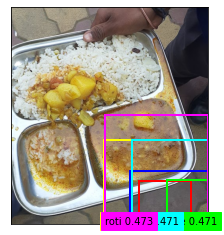

In [ ]:
l = predict(img, model, LABELS, ANCHORS)

In [ ]:
for i in l:
  print(i)

xmin: 0.6539070047651019, ymin: 0.8000326703701701, xmax: 0.9174729292733328, ymax: 1.0628250801137515, class: 2
xmin: 0.4753170020239694, ymin: 0.6128234544822148, xmax: 1.09631420816694, ymax: 1.243461615187781, class: 0
xmin: 0.7923476839065551, ymin: 0.7984121488673347, xmax: 1.064870206969125, ymax: 1.0604656802756447, class: 0
xmin: 0.6077883920499256, ymin: 0.7561186663593565, xmax: 1.2488044164010457, ymax: 1.102557665024485, class: 1
xmin: 0.6152333718538284, ymin: 0.6106537975583757, xmax: 1.2424408692121505, ymax: 1.245335079601833, class: 2
xmin: 0.47975138459886824, ymin: 0.4975207955496652, xmax: 1.3736462572642734, ymax: 1.3594263539995466, class: 1
